# Geospatial Image Analysis

This notebook contains my solution to the Data Scientist Challenge Project form Open Cosmos, as specified in [instructions](../Data_Scientist_Challenge_Project.pdf).

In the challenge, 2 scenes captured by Sentinel 2 are provided, along with a Region of Interest (ROI) and a set of points for each scene. The **objectives** are:

1. Crop all the bands in each scene to their associated ROI.
2. Compute the NDVI and NDWI maps of the cropped bands.
3. Extract the inland water body shapes in the cropped bands.
4. Identify the shapes of the water bodies associated to the provided sets of points and store them in a vectorized format.

For more information on the challenge and related practical aspects (e.g., dependencies, etc.), please check the [`README.md`](../README.md) file.

Additional notes:

- This is a research notebook; the transformed production code is contained in the upper level, implemented as a package.
- Assuming all the dependencies are installed, the notebook can be executed in sequence, i.e., just hit `Run All Cells` and enjoy. **However, you need to choose the `SCENE` in [section 2](#2.-Inspect-and-Visualize-Scene-Datasets)**. In other words, except in sections 5 and 6, the code is generic and it can be run for any scene. In sections 5 and 6 we need to use ad-hoc, manually tuned parameters.

Table of contents:

- [1. Imports and Definitions](#1.-Imports-and-Definitions)
- [2. Inspect and Visualize Scene Datasets](#2.-Inspect-and-Visualize-Scene-Datasets)
- [3. Resample, Crop and Persist Images (Objective 1)](#3.-Resample,-Crop-and-Persist-Images-(Objective-1))
- [4. Compute the NDVI and the NDWI Indices (Objective 2)](#4.-Compute-the-NDVI-and-the-NDWI-Indices-(Objective-2))
  - [4.1 NDVI](#4.1-NDVI)
  - [4.2 NDWI](#4.2-NDWI)
- [5. Get Water Shapes (Objective 3)](#5.-Get-Water-Shapes-(Objective-3))
- [6. Identify Lake Polygons (Objective 4)](#6.-Identify-Lake-Polygons-(Objective-4))

Each (sub-)section has a summary of the goals/achievements in it.

## 1. Imports and Definitions

We write all imports in the beginning to facilitate the the transformation to production code; note that the import order is PEP8 compliant. Constant variable definitions are contained here, too, due to the same reason. Some imports will be prunned in the production code.

In [150]:
import sys
import os
from glob import glob

import numpy as np
import pandas as pd
import geopandas as gpd
import contextily
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from earthpy.spatial import bytescale

import rasterio as rio
from rasterio.windows import Window
from rasterio.transform import Affine
from rasterio.features import shapes
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

from shapely.geometry import box
from shapely.geometry import shape

# Appending aux paths
sys.path.append('../utils')
from resample_raster import resample_res, resample_scale

In [152]:
# These paths should contain the contents of the original challenge.
DATA_PATH = "../data/"
SCENE_1_PATH = DATA_PATH + "Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910"
SCENE_2_PATH = DATA_PATH + "Scene 2 - S2B_MSIL1C_20230102T113359_N0509_R080_T30UWG_20230102T121121"

In [3]:
# lng/lat format in EPSG:4326 - WGS84, located in the UK
SCENE_1_BBOX = [-3.480290297664652, 54.26510479276385, -2.9010711619639267, 54.61995328561707]
SCENE_2_BBOX = [-2.815247, 55.102730, -1.450195, 55.553495]

## 2. Inspect and Visualize Scene Datasets

**IMPORTANT**: Select the scene number `1` or `2` here; then, you can run all cells in sequence and all the results will be generated for the desired scene.

In this section, a basic exploratory analysis is conducted, following these steps:

- Load the bands and the GeoJSON files.
- Create a GeoSeries with the ROI.
- Transform all objects to a common CRS (the one of the bands).
- Inspect band metadata (size, transform, etc.).
- Plot RBG image, if possible (Scene 2 lacks of Green channel/band).
- Plot band histograms.
- Plot the ROI and the points of interest on a band image.

Note that in this section a resampling is applied to scale down all bands to the lowest resolution (60m) in order to be able to handle them stacked together. The resampling code is located in [`../utils/resample_raster.py`](../utils/resample_raster.py).

In [153]:
# Choose the scene
SCENE = 1
#SCENE = 2

In [5]:
SCENE_PATH = SCENE_1_PATH
SCENE_BBOX = SCENE_1_BBOX
if SCENE == 2:
    SCENE_PATH = SCENE_2_PATH
    SCENE_BBOX = SCENE_2_BBOX

In [6]:
# Create a GeoSeries with the ROI
bbox = box(minx=SCENE_BBOX[0], miny=SCENE_BBOX[1], maxx=SCENE_BBOX[2], maxy=SCENE_BBOX[3], ccw=True)
gdf_bbox = gpd.GeoSeries([bbox], crs = 'epsg:4326')

In [7]:
# Load band filenames
sentinel_bands = glob(SCENE_PATH+"/*B?*.tiff")

In [8]:
# Load points of interest (GeoJSON)
gdf_points = gpd.read_file(SCENE_PATH+'/lakes.geojson')

In [9]:
gdf_points.head()

,id,geometry
0,Lake D,POINT (-2.48402 55.18325)
1,Lake E,POINT (-1.62511 55.28299)


In [10]:
# Print CRS of points
print(gdf_points.crs)

epsg:4326


In [11]:
sentinel_bands.sort()
sentinel_bands

['../data/Scene 2 - S2B_MSIL1C_20230102T113359_N0509_R080_T30UWG_20230102T121121/B01_COG.tiff',
 '../data/Scene 2 - S2B_MSIL1C_20230102T113359_N0509_R080_T30UWG_20230102T121121/B02_COG.tiff',
 '../data/Scene 2 - S2B_MSIL1C_20230102T113359_N0509_R080_T30UWG_20230102T121121/B04_COG.tiff',
 '../data/Scene 2 - S2B_MSIL1C_20230102T113359_N0509_R080_T30UWG_20230102T121121/B06_COG.tiff',
 '../data/Scene 2 - S2B_MSIL1C_20230102T113359_N0509_R080_T30UWG_20230102T121121/B07_COG.tiff',
 '../data/Scene 2 - S2B_MSIL1C_20230102T113359_N0509_R080_T30UWG_20230102T121121/B08_COG.tiff',
 '../data/Scene 2 - S2B_MSIL1C_20230102T113359_N0509_R080_T30UWG_20230102T121121/B09_COG.tiff',
 '../data/Scene 2 - S2B_MSIL1C_20230102T113359_N0509_R080_T30UWG_20230102T121121/B10_COG.tiff',
 '../data/Scene 2 - S2B_MSIL1C_20230102T113359_N0509_R080_T30UWG_20230102T121121/B11_COG.tiff',
 '../data/Scene 2 - S2B_MSIL1C_20230102T113359_N0509_R080_T30UWG_20230102T121121/B12_COG.tiff',
 '../data/Scene 2 - S2B_MSIL1C_20230102T

In [12]:
# Extract band names
# FIXME: Improve with regex...
band_names = [band.split(os.sep)[-1][1:3] for band in sentinel_bands]

In [13]:
band_names

['01', '02', '04', '06', '07', '08', '09', '10', '11', '12', '8A']

In [14]:
# Open one band and get CRS
src = rio.open(sentinel_bands[1])

In [15]:
print(src.crs)

EPSG:32630


In [16]:
# Transform points of interest to band CRS
gdf_points = gdf_points.to_crs(src.crs)

In [17]:
gdf_points

,id,geometry
0,Lake D,POINT (532855.512 6115304.837)
1,Lake E,POINT (587326.887 6127144.219)


In [18]:
# Transform ROIs to band CRS
gdf_bbox = gdf_bbox.to_crs(src.crs)

In [19]:
gdf_bbox

0    POLYGON ((598881.135 6107320.169, 597765.080 6...
dtype: geometry

In [20]:
# Inspect some metadata of the bands: count, size, etc.
src.count

1

In [21]:
src.width, src.height

(10980, 10980)

In [22]:
src.bounds # bbox

BoundingBox(left=499980.0, bottom=6090240.0, right=609780.0, top=6200040.0)

In [23]:
src.offsets

(0.0,)

In [24]:
src.res # resolution

(10.0, 10.0)

In [25]:
src.transform

Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 6200040.0)

In [26]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32630), 'transform': Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 6200040.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [27]:
# Open band rasters with rasterio
# Resample/Resize if needed: I would take the minimum resolution (60m)
images = []
xres = 60
yres = 60
resample = True
for i in sentinel_bands:
    with rio.open(i, 'r') as src:
        img = None
        profile = None
        if resample:
            img, profile = resample_res(src, xres, yres)
        else:
            img, profile = src.read(1), src.profile
        images.append(img)
        # Display
        print(f"New shape: {img.shape}, org. resolution: {src.res}")

New shape: (1, 1830, 1830), org. resolution: (60.0, 60.0)
New shape: (1, 1830, 1830), org. resolution: (10.0, 10.0)
New shape: (1, 1830, 1830), org. resolution: (10.0, 10.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (10.0, 10.0)
New shape: (1, 1830, 1830), org. resolution: (60.0, 60.0)
New shape: (1, 1830, 1830), org. resolution: (60.0, 60.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)


In [28]:
# Stack all image channels/bands to form a multi-channel pixelmap
images_array = np.stack(images).squeeze()

In [29]:
images_array.shape

(11, 1830, 1830)

In [30]:
# Min grayvalue
images_array.min()

0

In [31]:
# Max grayvalue
images_array.max()

17376

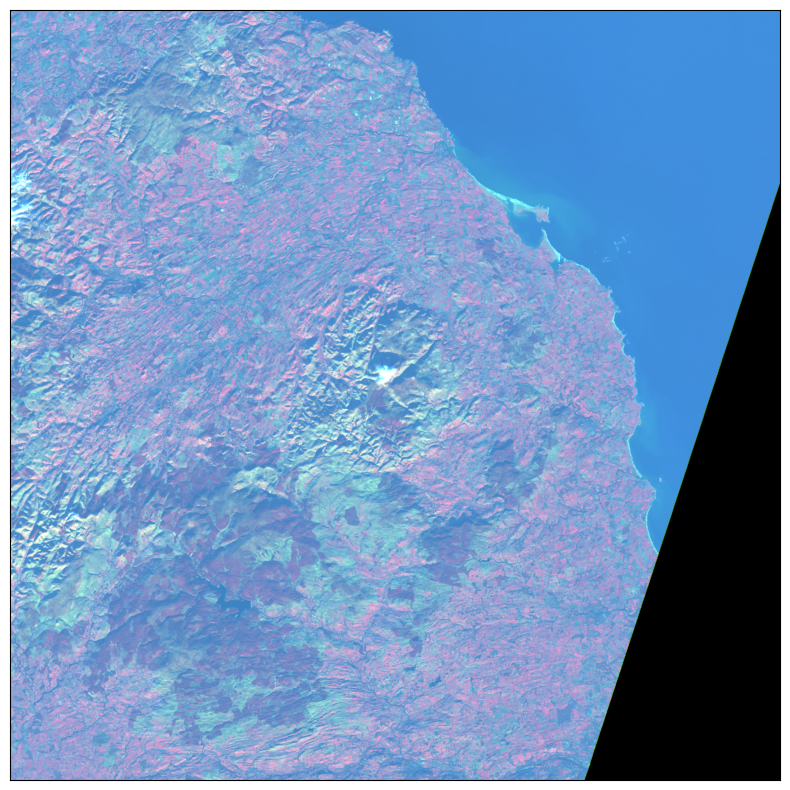

In [32]:
# Plot RGB image
# Scene 2 has no green channel/band, so RGB is not possible
rgb = ep.plot_rgb(images_array[1:4], 
                  rgb=(2,1,0), # (default = (0, 1, 2))) indices of the three RGB bands,
                  stretch=True, # apply linear stretch
                  str_clip=0.2, # pcnt of clip in linear stretch, default 2 = 2%
                  figsize=(10, 10))
plt.show()

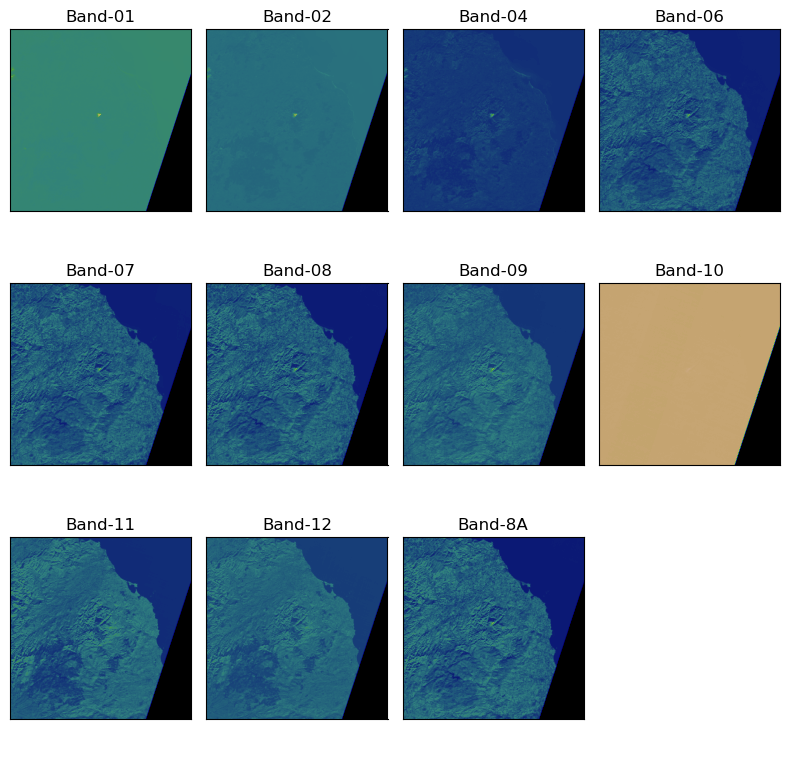

In [33]:
# Plot all bands to check for errors.
# Some bands might have low contrast, i.e., their histogram
# is expected to have a peak, due to a narrow range of intensity values.
ep.plot_bands(images_array, 
              cmap='gist_earth',
              title=[f"Band-{name}" for name in band_names],
              figsize=(8, 8),
              cols=4,
              cbar=False)
plt.show()

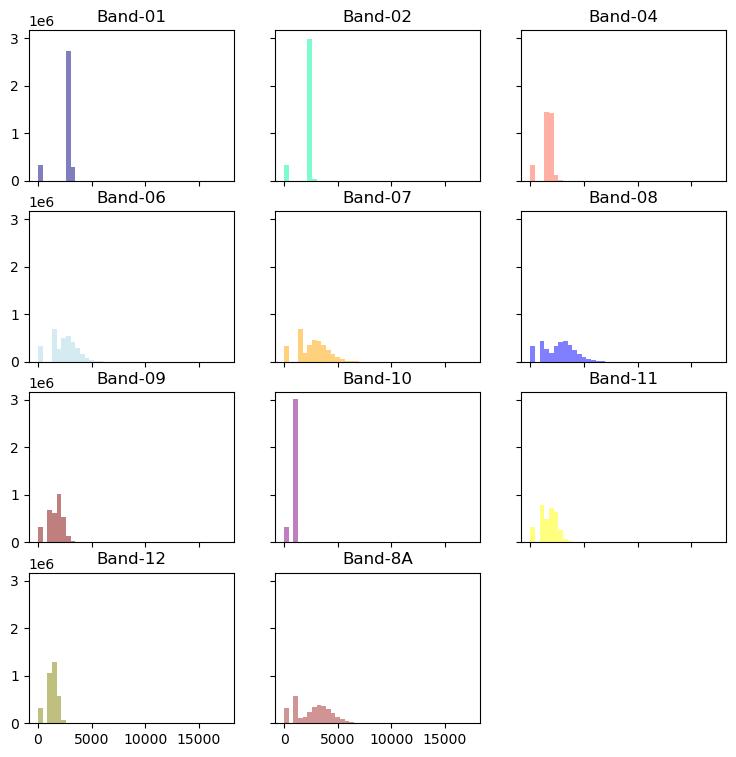

In [34]:
# Pixel value distributions: histograms
# Some bands might have low contrast, i.e., their histogram
# is expected to have a peak, due to a narrow range of intensity values.
colors = ['navy', 'MediumSpringGreen', 'tomato', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan', 'navy']
ep.hist(images_array, 
        colors = colors,
        #title=[f'Band-{i}' for i in range(1, len(sentinel_bands)+1)], 
        title=[f'Band-{name}' for name in band_names], 
        cols=3, 
        alpha=0.5, 
        figsize=(9, 9),
        bins=40)
plt.show()

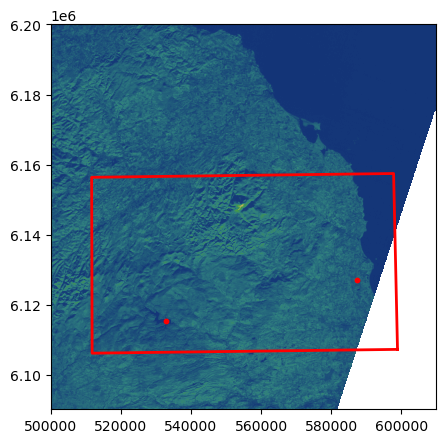

In [35]:
# Select a band and plot geometries on it (points & cropping bbox, i.e., ROI)
# After visual inspection, the ROI is not rectangular (Scene 2, 1)
band_name = sentinel_bands[6]
with rio.open(band_name, 'r') as src:
    fig, ax = plt.subplots(figsize=(5, 5))
    rio.plot.show(src, ax=ax, adjust=True, cmap="gist_earth")
    gdf_points.plot(ax=ax, markersize=10, color='red')
    #gdf_bbox.plot(ax=ax, color='red', facecolor="green")
    ax.plot(*gdf_bbox[0].exterior.xy, color='red', linewidth=2)
    plt.show()

## 3. Resample, Crop and Persist Images (Objective 1)

This section contains the processing necessary to accomplish objective 1.

Starting from this from this section, the code will be transferred to the production environment, thus reusable functions are defined and exception handling is used.

Accomplished tasks:

- Function `resample_persist_band()`: given a band path, it resamples and stores it to disk.
- Resample and save all bands.
- Function `crop_persist_band()`: given a band path, it crops and stores it to disk.
- Crop and save all bands.
- Function `load_band_image()`: given a band path, load it and resample it if desired.
- Load all cropped bands.
- Plot cropped, saved bands.
- Plot band histograms and their characteristics (mean & std).

In [36]:
# FIXME: refactor to two functions: resample & persist and use persistence manager
def resample_persist_band(input_path,
                          output_path,
                          resolution=(60,60)):
    """Resample band pixelmap to spcified resolution
    and persist.
    
    Args:
        input_path (str): input filename of the band/channel image pixelmap
        output_path (str): output filename of the band/channel image pixelmap
        resolution (tuple[float]): x and y resolution to resample

    Returns: None
    """
    xres = resolution[0]
    yres = resolution[1]
    with rio.open(input_path, 'r') as src:
        img, profile = resample_res(src, xres, yres)
    
    with rio.open(output_path, "w", **profile) as dataset:
        dataset.write(img)

In [37]:
# Create a folder to store all processed images images
try:
    output_path = os.path.join(SCENE_PATH, "processed")
    os.mkdir(output_path)
except FileExistsError as err:
    print("Folder already exists.")

Folder already exists.


In [38]:
# Resample and save all files
for band in sentinel_bands:
    input_file = band
    filename = input_file.split(os.sep)[-1]
    output_file = os.path.join(SCENE_PATH, "processed", filename)
    try:
        assert os.path.isfile(input_file)
        resample_persist_band(input_path=input_file,
                              output_path=output_file,
                              resolution=(60,60))
    except AssertionError as err:
        print(f"resample_persist_band: input_file does not exist: {input_file}")

In [39]:
# FIXME: refactor to two functions: crop & persist and use persistence manager
def crop_persist_band(input_path, output_path, shapes):
    """Load band from input path,
    crop it according to the geometries in shapes
    and persist to filepath in output_path.
    
    Args:
        input_path (str): path of the band file
        output_path (str): path to persist cropped band
        shapes (gepandas.GeoSeries): iterable with geometries to crop
    
    Returns:
        out_image (numpy.ndarray): copped image/band array
        out_meta (dict): dictionary with band information
            (i.e., CRS, affine transformation matrix, etc.)
    """
    with rio.open(input_file, "r") as src:
        out_image, out_transform = rio.mask.mask(src,
                                                 shapes,
                                                 crop=True)
        out_meta = src.meta
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
        with rio.open(output_file, "w", **out_meta) as dest:
            dest.write(out_image)
        
    return out_image, out_meta

In [40]:
# Test: Use crop_persist_band in local folder
input_file = sentinel_bands[8]
output_file = "test_raster.tiff"
out_image, out_meta = crop_persist_band(input_path=input_file,
                                        output_path=output_file,
                                        shapes=gdf_bbox)

In [41]:
# Test: Get band std; each band should have a a different value,
# it's a sanity check
out_image.std()

818.2825175265452

In [42]:
# Test: Inspect meta info
out_meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 0.0,
 'width': 4363,
 'height': 2563,
 'count': 1,
 'crs': CRS.from_epsg(32630),
 'transform': Affine(20.0, 0.0, 511640.0,
        0.0, -20.0, 6157480.0)}

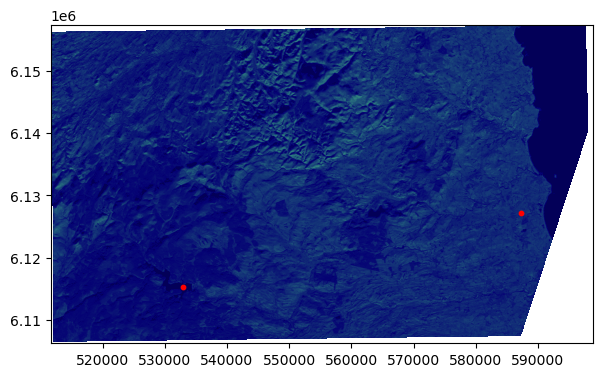

In [43]:
# Test: Load and plot cropped band and display points of interest on it
band_name = output_file
with rio.open(band_name, 'r') as src:
    fig, ax = plt.subplots(figsize=(7, 7))
    rio.plot.show(src, ax=ax, adjust=True, cmap="gist_earth")
    gdf_points.plot(ax=ax, markersize=10, color='red')
    plt.show()

In [44]:
# Get paths of resampled bands
sentinel_bands = glob(os.path.join(SCENE_PATH, "processed", "*B?*.tiff"))
sentinel_bands.sort()

In [45]:
# Crop all bands
for band in sentinel_bands:
    input_file = band
    filename = input_file.split(os.sep)[-1]
    output_file = os.path.join(SCENE_PATH, "processed", filename)
    try:
        assert os.path.isfile(input_file)
        _, _ = crop_persist_band(input_path=input_file,
                                 output_path=output_file,
                                 shapes=gdf_bbox)
    except AssertionError as err:
        print(f"crop_persist_band: input_file does not exist: {input_file}")

In [46]:
def load_band_image(filename, resample=False, resolution=(60,60)):
    """Load a band file and resample (resize) it
    if required.
    
    Args:
        filename (str): filename of the band/channel image pixelmap
        resample (bool): resample/resize or not (default: False)
        resolution (tuple[float]): x and y resolution to resample
            (default: (60,60))

    Returns:
        img (numpy.ndarray): band array, image
        profile (dict): dictionary with band profile meta-info
        band_name (str): band name (1, 2, ...)
    """
    xres = resolution[0]
    yres = resolution[1]
    resample = True
    # FIXME: use regex in future, or a more generic way...
    band_name = filename.split(os.sep)[-1][1:3]
    with rio.open(filename, 'r') as src:
        img = None
        profile = None
        if resample:
            img, profile = resample_res(src, xres, yres)
        else:
            img, profile = src.read(1), src.profile

    return img, profile, band_name

In [47]:
# Test: load one band
test_filename = "../data/Scene 1 - S2A_MSIL1C_20230223T112111_N0509_R037_T30UVF_20230223T145910/processed/B01_COG.tiff"
img, profile, band_name = load_band_image(filename=test_filename,
                                          resample=True,
                                          resolution=(60,60))

In [48]:
# Load all cropped bands
sentinel_bands = glob(os.path.join(SCENE_PATH, "processed", "*B?*.tiff"))
sentinel_bands.sort()
images = []
profiles = []
band_names = []
for band_filename in sentinel_bands:
    try:
        assert os.path.isfile(band_filename)
        img, profile, band_name = load_band_image(filename=band_filename,
                                                  resample=False,
                                                  resolution=(60,60))
        images.append(img)
        profiles.append(profile)
        band_names.append(band_name)        
    except AssertionError as err:
        print(f"load_band_image: band_filename does not exist: {band_filename}")

In [49]:
# Test: are they all resampled to the same size?
for i in images:
    print(i.shape)

(1, 855, 1455)
(1, 855, 1455)
(1, 855, 1455)
(1, 855, 1455)
(1, 855, 1455)
(1, 855, 1455)
(1, 855, 1455)
(1, 855, 1455)
(1, 855, 1455)
(1, 855, 1455)
(1, 855, 1455)


In [50]:
# Pick one profile
profile = profiles[0]

In [51]:
# Stack all image channels/bands
images_array = np.stack(images).squeeze()

In [52]:
images_array.shape

(11, 855, 1455)

In [53]:
band_names

['01', '02', '04', '06', '07', '08', '09', '10', '11', '12', '8A']

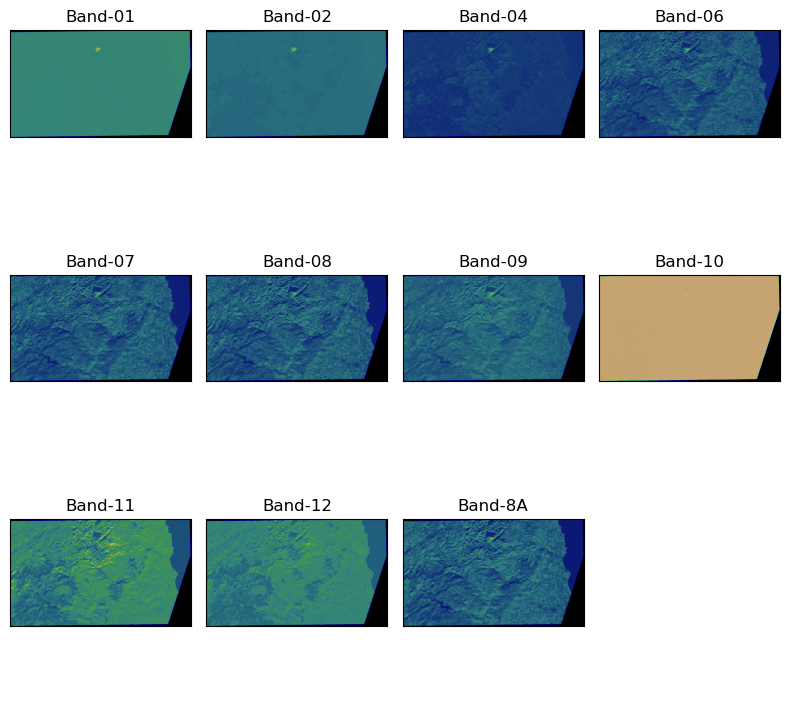

In [54]:
# Plot all bands
ep.plot_bands(images_array, 
              cmap='gist_earth',
              title=[f"Band-{name}" for name in band_names],
              figsize=(8, 8),
              cols=4,
              cbar=False)
plt.show()

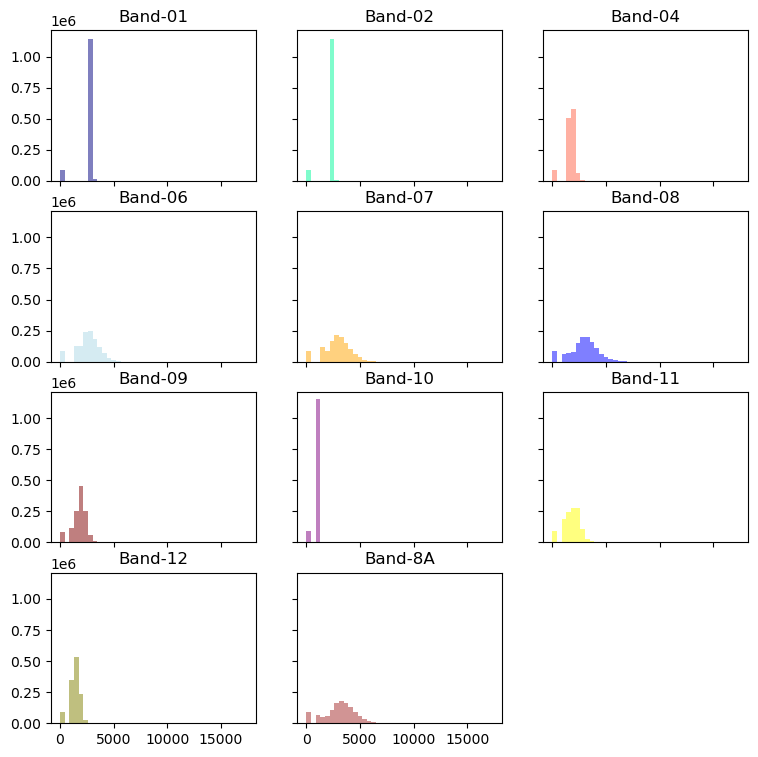

In [55]:
# Pixel value distributions: histograms
colors = ['navy', 'MediumSpringGreen', 'tomato', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan', 'navy']
ep.hist(images_array, 
        colors = colors,
        #title=[f'Band-{i}' for i in range(1, len(sentinel_bands)+1)], 
        title=[f'Band-{name}' for name in band_names], 
        cols=3, 
        alpha=0.5, 
        figsize=(9, 9),
        bins=40)
plt.show()

In [56]:
# Low standard deviations indicate very concentrated histograms,
# i.e., pixel values are not very distributed, i.e., less information contained
means = [images_array[b].mean() for b in range(images_array.shape[0])]
stds = [images_array[b].std() for b in range(images_array.shape[0])]
for b, m in enumerate(means):
    print(f"band {band_names[b]}: mean = {m}; std = {images_array[b].std()}")

band 01: mean = 2678.598951789554; std = 747.9317961097437
band 02: mean = 2254.3353815236833; std = 638.7890375107683
band 04: mean = 1666.8243355238037; std = 521.6763978997071
band 06: mean = 2622.6580727879264; std = 1085.0766047530205
band 07: mean = 2875.8732131588995; std = 1254.6417559775623
band 08: mean = 2907.066033238882; std = 1300.5615007268746
band 09: mean = 1810.8449597074014; std = 673.7878001713749
band 10: mean = 949.1101055043106; std = 265.73314409616165
band 11: mean = 1835.5594919716243; std = 791.7020464513917
band 12: mean = 1406.25306726151; std = 506.4144036795771
band 8A: mean = 3131.2824750306463; std = 1442.6146074640867


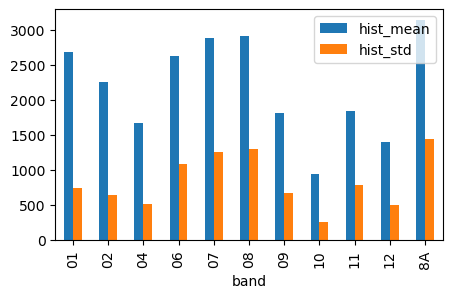

In [57]:
# Plot the histogram mean & stds
df_hist = pd.DataFrame({'band': band_names, 'hist_mean': means, 'hist_std': stds}).set_index('band')
df_hist.plot(kind='bar', figsize=(5,3))
plt.savefig(f'../assets/scene_{SCENE}_hist_params.png',dpi=300,transparent=False,bbox_inches='tight')

## 4. Compute the NDVI and the NDWI Indices (Objective 2)

This section accomplishes the objective 2.

The following tasks are carried out:

- Function `compute_ndvi()`: given band arrays, comute the NDVI map.
- Function `compute_ndwi()`: given band arrays, comute the NDWI map.
- Function `generate_persist_ndmap()`: given band arrays, comute either the NDVI or NDWI map and save it to disk.
- Compute and persist the NDVI and NDWI maps for the scene.
- Load the NDVI and NDWI maps and visualize them.

*Note: unfortunately, the NDWI map of scene 2 seems to be useless.*

---

Definitions:

- NDVI: [Normalized Difference Vegetation Index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)
- NDWI: [Normalized Difference Water Index](https://en.wikipedia.org/wiki/Normalized_difference_water_index)

Necessary [bands](https://gisgeography.com/sentinel-2-bands-combinations/):

- NIR: Near-infrared band; either band B8 or B8A
- Red: Red band; B4
- Green: Green band; B3
- SWIR: B11 or B12

Computation:

    NDVI = (NIR - Red) / (NIR + Red) = (B8 - B4) / (B8 + B4)
    NDWI = (Green - NIR) / (Green + NIR) = (B3 - B8) / (B3 + B8)
    
Note on NDWI: In case we don't have the Green band (B3), we can approximate the index using a showrtwave infrared (SWIR) band (i.e., B11 or B12) and the near infrared band (B8 or B8A):

    NDWI = (NIR - SWIR) / (NIR + SWIR) (approx.)
    NDWI = (B8A - B12) / (B8A + B12) (approx.)
    NDWI = (B8A - B11) / (B8A + B11) (approx.)


In [58]:
band_names

['01', '02', '04', '06', '07', '08', '09', '10', '11', '12', '8A']

### 4.1 NDVI

In [59]:
def compute_ndvi(images, band_names):
    """Compute the Normalized Difference
    Vegetation Index (NDVI) pixelmap.

    NDVI = (NIR - Red) / (NIR + Red)
         = (B8 - B4) / (B8 + B4)

    Args:
        images (numpy.ndarray): array with images
            in a 3D shape: band, width, height
        band_names (list[str]): band names associated
            to the images, e.g.: ['01', '02', ..., '08A']

    Returns:
        ndvi (numpy.ndarray): NDVI pixelmap
    """
    # Initialize
    red_idx = None
    nir_idx = None
    ndvi = None

    # Get the indices of the Red and NIR bands
    red_idx = band_names.index('04') if '04' in band_names else None
    nir_idx = band_names.index('08') if '08' in band_names else None

    # Get the corresponding bands
    if red_idx and nir_idx:
        red_band = images[red_idx].squeeze()
        nir_band = images[nir_idx].squeeze()

        # Compute NDVI; default fivision by 0 to 0
        with np.errstate(divide='ignore', invalid='ignore'):
            ndvi = np.nan_to_num((nir_band - red_band) / (nir_band + red_band))

    return ndvi

In [60]:
# Compute the NDVI map
ndvi = compute_ndvi(images_array, band_names)

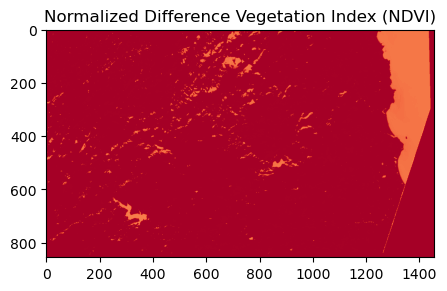

In [61]:
# Visualize the NDVI raster
fig, ax = plt.subplots(figsize=(5, 5))
rio.plot.show(ndvi, ax=ax, cmap="RdYlGn")
ax.set_title("Normalized Difference Vegetation Index (NDVI)")
plt.show()

In [62]:
# WARNING: DO NOT USE THIS!
# Instead, use generate_persist_ndmap, defined below!
def generate_persist_ndvi(images, band_names, profile, output_path):
    """Compute the Normalized Difference
    Vegetation Index (NDVI) pixelmap and store it
    to the specified file.
    
    Args:
        images (numpy.ndarray): array with images
            in a 3D shape: band, width, height
        band_names (list[str]): band names associated
            to the images, e.g.: ['01', '02', ..., '08A']
        profile (dict): profile dictionary of the source bands
        output_path (str): file path to persist the NDVI pixelmap

    Returns:
        ndvi (numpy.ndarray): NDVI pixelmap
        ndvi_profile (dict) profile dictionary of the NDVI pixelmap
    """
    # Initialize
    ndvi = None
    ndvi_profile = None
    
    # Compute NDVI
    ndvi = compute_ndvi(images, band_names)
    
    # Store if we obtained something from compute_ndvi
    if ndvi.any() or ndvi_profile:    
        # Create new profile for NDVI image
        ndvi_profile = profile.copy()
        ndvi_profile['count'] = 1
        ndvi_profile['dtype'] = 'float32'
        ndvi_profile['nodata'] = -9999

        # Create a transform for the NDVI image
        transform = profile['transform']
        ndvi_transform = Affine(transform.a, transform.b, transform.c, transform.d, transform.e, transform.f)

        # Write the NDVI image to disk
        with rio.open(output_path, 'w', **ndvi_profile) as ndvi_ds:
            ndvi_ds.write(ndvi, 1)
            ndvi_ds.transform = ndvi_transform
    else:
        print("generate_persist_ndvi: bands are missing to compute NDVI.")
    
    return ndvi, ndvi_profile

In [63]:
output_path = os.path.join(SCENE_PATH, "processed", "ndvi.tiff")
print(output_path)
ndvi, ndvi_profile = generate_persist_ndvi(images_array,
                                           band_names,
                                           profile,
                                           output_path)

../data/Scene 2 - S2B_MSIL1C_20230102T113359_N0509_R080_T30UWG_20230102T121121/processed/ndvi.tiff


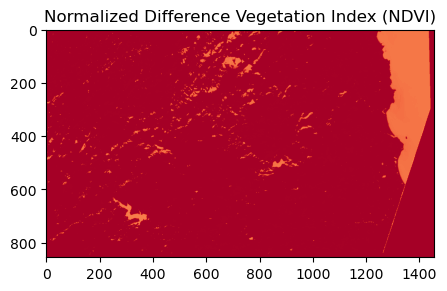

In [64]:
# Check: Load pixelmap and visualize it
with rio.open(output_path, 'r') as src:
    img, profile = src.read(1), src.profile
    fig, ax = plt.subplots(figsize=(5, 5))
    rio.plot.show(ndvi, ax=ax, cmap="RdYlGn")
    ax.set_title("Normalized Difference Vegetation Index (NDVI)")
    plt.show()

### 4.2 NDWI

In [65]:
def compute_ndwi(images, band_names):
    """Compute the Normalized Difference Water
    Index (NDWI) pixelmap.

    NDWI = (Green - NIR) / (Green + NIR)
         = (B3 - B8) / (B3 + B8)

    or, in the absence of Green (B3)
        
    NDWI = (NIR - SWIR) / (NIR + SWIR) (approx.)
         = (B8A - B12) / (B8A + B12) (approx.)
         = (B8A - B11) / (B8A + B11) (approx.

    Args:
        images (numpy.ndarray): array with images
            in a 3D shape: band, width, height
        band_names (list[str]): band names associated
            to the images, e.g.: ['01', '02', ..., '08A']

    Returns:
        ndwi (numpy.ndarray): NDWI pixelmap
    """
    # Initialize
    green_idx = None
    nir_idx = None
    swir_idx = None
    swir_12_idx = None
    swir_11_idx = None
    ndwi = None
    standard = False
    
    # Get the indices of the Red and NIR bands
    green_idx = band_names.index('03') if '03' in band_names else None
    nir_idx = band_names.index('8A') if '8A' in band_names else None
    swir_idx = band_names.index('12') if '12' in band_names else None
    swir_11_idx = band_names.index('11') if '11' in band_names else None

    # Select formula with available
    if green_idx and nir_idx:
        standard = True
    else:
        if swir_12_idx:
            swir_idx = swir_12_idx
        elif swir_11_idx:
            swir_idx = swir_11_idx
    
    if standard:
        # NDWI = (Green - NIR) / (Green + NIR)
        green_band = images[green_idx].squeeze()
        nir_band = images[nir_idx].squeeze()

        # Compute NDWI; default fivision by 0 to 0
        with np.errstate(divide='ignore', invalid='ignore'):
            ndwi = np.nan_to_num((green_band - nir_band) / (green_band + nir_band))
            
    elif swir_idx:
        # NDWI = (NIR - SWIR) / (NIR + SWIR) (approx.)
        swir_band = images[swir_idx].squeeze()
        nir_band = images[nir_idx].squeeze()

        # Compute NDWI; default fivision by 0 to 0
        with np.errstate(divide='ignore', invalid='ignore'):
            ndwi = np.nan_to_num((nir_band - swir_band) / (nir_band - swir_band))

    return ndwi

In [66]:
# Compute NDWI map
ndwi = compute_ndwi(images_array, band_names)

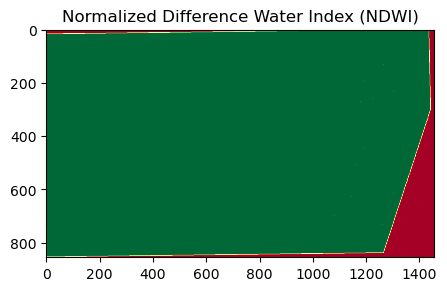

In [67]:
# Visualize the NDWI raster
fig, ax = plt.subplots(figsize=(5, 5))
rio.plot.show(ndwi, ax=ax, cmap="RdYlGn")
ax.set_title("Normalized Difference Water Index (NDWI)")
plt.show()

In [68]:
def generate_persist_ndmap(images,
                           band_names,
                           profile,
                           output_path,
                           map_type="ndvi"):
    """Compute and store a normalized difference map,
    either:
    
    - Normalized Difference Vegetation Index (NDVI), or
    - Normalized Difference Water Index (NDWI)
    
    Args:
        images (numpy.ndarray): array with images
            in a 3D shape: band, width, height
        band_names (list[str]): band names associated
            to the images, e.g.: ['01', '02', ..., '08A']
        profile (dict): profile dictionary of the source bands
        output_path (str): file path to persist the NDVI pixelmap
        map_type (str): "ndvi" for NDVI, "ndwi" for NDWI

    Returns:
        ndmap (numpy.ndarray): ND pixelmap
        ndmap_profile (dict) profile dictionary of the ND pixelmap
    """
    # Initialize
    ndmap = None
    ndmap_profile = None
    
    # Compute NDVI
    if map_type == "ndvi":
        ndmap = compute_ndvi(images, band_names)
    elif map_type == "ndwi":
        ndmap = compute_ndwi(images, band_names)
    else:
        print(f"generate_persist_ndmap: not valid map_type: {map_type}")

    # Store if we obtained something from compute_ndvi
    if ndmap.any() or ndmap_profile:    
        # Create new profile for NDVI image
        ndmap_profile = profile.copy()
        ndmap_profile['count'] = 1
        ndmap_profile['dtype'] = 'float32'
        ndmap_profile['nodata'] = -9999

        # Create a transform for the NDVI image
        transform = profile['transform']
        ndmap_transform = Affine(transform.a, transform.b, transform.c, transform.d, transform.e, transform.f)

        # Write the NDVI image to disk
        with rio.open(output_path, 'w', **ndmap_profile) as ndmap_ds:
            ndmap_ds.write(ndmap, 1)
            ndmap_ds.transform = ndmap_transform
    else:
        print("generate_persist_ndvi: bands are missing to compute NDVI.")
    
    return ndmap, ndmap_profile

In [69]:
# Compute and persist the NDVI map for the scene
output_path = os.path.join(SCENE_PATH, "processed", "ndvi.tiff")
print(output_path)
ndvi, ndvi_profile = generate_persist_ndmap(images_array,
                                            band_names,
                                            profile,
                                            output_path,
                                            map_type="ndvi")

../data/Scene 2 - S2B_MSIL1C_20230102T113359_N0509_R080_T30UWG_20230102T121121/processed/ndvi.tiff


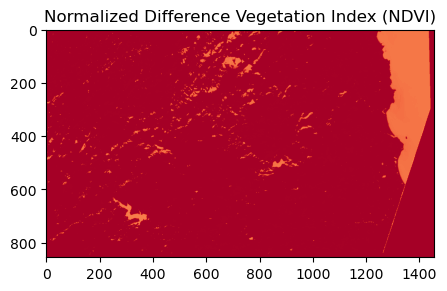

In [70]:
# Check: Load pixelmap and visualize it
with rio.open(output_path, 'r') as src:
    img, profile = src.read(1), src.profile
    fig, ax = plt.subplots(figsize=(5, 5))
    rio.plot.show(img, ax=ax, cmap="RdYlGn")
    ax.set_title("Normalized Difference Vegetation Index (NDVI)")
    plt.show()

In [71]:
# Compute and persist the NDWI map for the scene
output_path = os.path.join(SCENE_PATH, "processed", "ndwi.tiff")
print(output_path)
ndwi, ndwi_profile = generate_persist_ndmap(images_array,
                                            band_names,
                                            profile,
                                            output_path,
                                            map_type="ndwi")

../data/Scene 2 - S2B_MSIL1C_20230102T113359_N0509_R080_T30UWG_20230102T121121/processed/ndwi.tiff


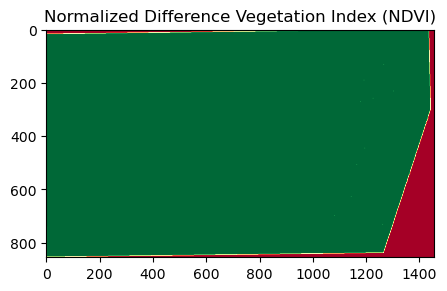

In [72]:
# Check: Load pixelmap and visualize it
with rio.open(output_path, 'r') as src:
    img, profile = src.read(1), src.profile
    fig, ax = plt.subplots(figsize=(5, 5))
    rio.plot.show(img, ax=ax, cmap="RdYlGn")
    ax.set_title("Normalized Difference Vegetation Index (NDVI)")
    plt.show()

## 5. Get Water Shapes (Objective 3)

This section deals with objective 3.

In a regular situation, the NDWI map should be used to detect water bodies; however, since the scene 2 has no valid NDWI, I decided to employ the NDVI map instead &mdash; but the results are not convincing.

The following tasks are carried out:

- Load the saved NDVI or NDWI maps; each scene uses a different one.
- Perform therholding on the map to obtain a mask of the candidate water bodies.
- Convert the water body BLOBs into polygons of a GeoSeries.
- Plot the mask and the polygons.

Number of water polygons found: 6032


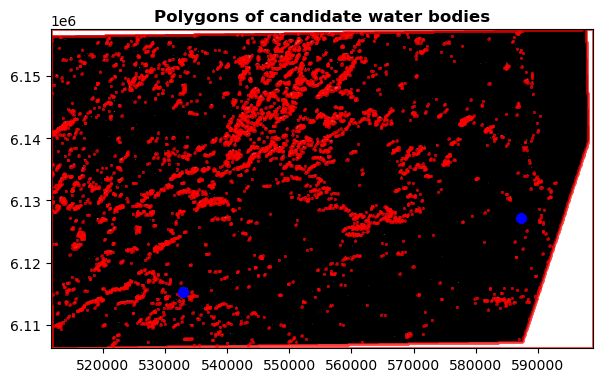

In [125]:
# Load ND-map raster file
filename = "ndwi.tiff"
if SCENE == 2:
    filename = "ndvi.tiff"
ndmap_filepath = os.path.join(SCENE_PATH, "processed", filename)

with rio.open(ndmap_filepath) as ndmap_src:
    ndmap = ndmap_src.read(1)
    ndmap_transform = ndmap_src.transform
    ndmap_crs = ndmap_src.crs

## Scene 1: NDWI
ndmap_threshold = 0.3
value_mask = 1
water_mask = np.where(ndmap > ndmap_threshold, abs(value_mask-1), value_mask)

## Scene 2: NDVI
if SCENE == 2:
    ndmap_threshold = 0.02
    value_mask = 1
    water_mask = np.where(ndmap < ndmap_threshold, value_mask, abs(value_mask-1))

# Generate polygons from water bodies
water_polygons = []
for single_water_mask, value in shapes(water_mask.astype(dtype='int16'), transform=ndmap_transform):
    if value == value_mask:
        water_polygons.append(shape(single_water_mask))

print("Number of water polygons found:", len(water_polygons))

# Convert water polygons to geoseries
water_geoseries = gpd.GeoSeries(water_polygons, crs=ndmap_crs)

# Plot masked raster and water polygons
fig, ax = plt.subplots(figsize=(7, 7))
rio.plot.show(water_mask,
              transform=ndmap_transform,
              ax=ax,
              cmap='gray',
              title="Polygons of candidate water bodies")
water_geoseries.plot(ax=ax,
                     alpha=0.75,
                     facecolor='none',
                     edgecolor='red',
                     linewidth=2)
gdf_points.plot(ax=ax, markersize=50, color='blue')
plt.show()

## 6. Identify Lake Polygons (Objective 4)

This section deals with the last objective.

We have a series of polygons that represent candidate water bodies; the goal is to select the polygons which contain or are closest to the target points provided in the challenge; then, the filtered polygons are tagged with the point id.

The following steps are taken:

- Filter the water body polygons: take the ones which contain or are closest to the target points.
- Assemble GeoDataFrame and save it to disk.
- Plot the final result: masked raster + select water polygons + original target points

<Axes: ylabel='Frequency'>

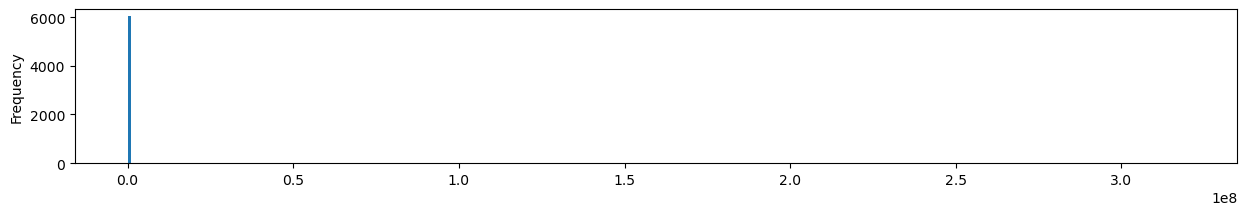

In [126]:
# Scene 1: We could prune many polygons with low and high areas
water_geoseries.area.plot(kind='hist', bins=300, figsize=(15,2))

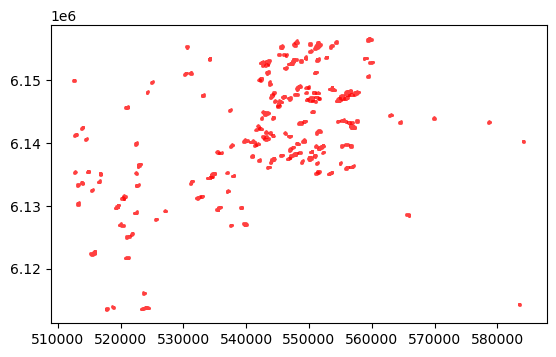

In [127]:
# Plot filtered polygons
# NOTE: I will not use this...
condition = ((water_geoseries.area > 10*water_geoseries.area.median()) & 
            (water_geoseries.area < 0.3*water_geoseries.area.max()))
water_geoseries[condition].plot(
                     alpha=0.75,
                     facecolor='none',
                     edgecolor='red',
                     linewidth=2)
plt.show()

In [128]:
# Print GeoDataFrame of target points
gdf_points

,id,geometry
0,Lake D,POINT (532855.512 6115304.837)
1,Lake E,POINT (587326.887 6127144.219)


In [129]:
# Filter water body polygons:
# take the ones which contain or are closest to the target points.
ids = []
polygons = []
for i, point in gdf_points.iterrows():
    ids.append(point.id)
    if SCENE == 1:
        mask = water_geoseries.contains(point.geometry)
        polygons.append(water_geoseries[mask].values[0])
    elif SCENE == 2:
        dist = water_geoseries.distance(point.geometry)
        closest = dist.argmin()
        polygons.append(water_geoseries.loc[closest])

In [130]:
# Filtered polygons
polygons

[<POLYGON ((533160 6115740, 533160 6115680, 533220 6115680, 533220 6115740, 5...>,
 <POLYGON ((587460 6127140, 587460 6127080, 587520 6127080, 587520 6127140, 5...>]

In [131]:
# Ids of polygons
ids

['Lake D', 'Lake E']

In [132]:
# Assemble GeoDataFrame and save it
gdf_lakes = gpd.GeoDataFrame({'id': ids, 'geometry': polygons}, crs = ndmap_crs)
gdf_filename = os.path.join(SCENE_PATH, "processed", f"scene_{SCENE}_lake_polygons.geojson")
gdf_lakes.to_file(gdf_filename, driver='GeoJSON')
# Load it again... (sanity check)
gdf_lakes = gpd.read_file(gdf_filename)

In [133]:
# Print results
gdf_lakes

,id,geometry
0,Lake D,"POLYGON ((533160.000 6115740.000, 533160.000 6..."
1,Lake E,"POLYGON ((587460.000 6127140.000, 587460.000 6..."


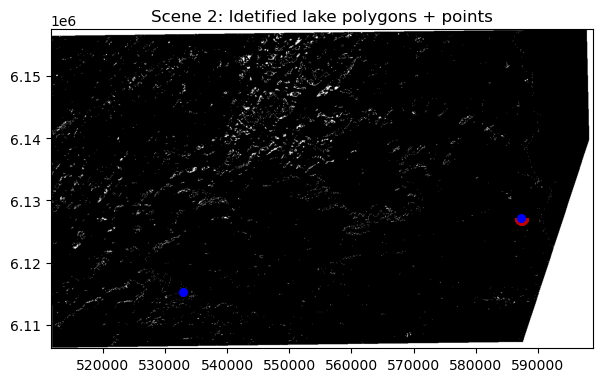

In [149]:
# Plot the final result:
# masked raster + select water polygons + original target points
fig, ax = plt.subplots(figsize=(7, 7))
rio.plot.show(water_mask,
              transform=ndmap_transform,
              ax=ax,
              cmap='gray')
gdf_lakes.plot(ax=ax,
               alpha=0.75,
               facecolor='none',
               edgecolor='red',
               linewidth=10) # 2
gdf_points.plot(ax=ax, markersize=30, color='blue')
plt.title(f"Scene {SCENE}: Idetified lake polygons + points")

plot_filename = os.path.join(SCENE_PATH, "processed", f"scene_{SCENE}_lake_polygons.png")
plt.savefig(plot_filename,dpi=200,transparent=False,bbox_inches='tight')
plt.show()

In [154]:
# Sanity check (scene 2)
gdf_lakes.distance(gdf_points.geometry.loc[0])

0      483.176862
1    55859.686219
dtype: float64

In [155]:
# Sanity check (scene 2)
gdf_lakes.distance(gdf_points.geometry.loc[1])

0    55295.673126
1      133.179580
dtype: float64